In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 85.70%
Success Probability Vector:
tensor([9.5552e-01, 1.0855e-03, 1.5017e-02, 1.7180e-03, 4.3235e-03, 3.3095e-04,
        9.6407e-04, 3.8746e-03, 1.2375e-02, 4.7906e-03], device='cuda:0')
Class 2 - Accuracy: 92.30%
Success Probability Vector:
tensor([3.7570e-03, 9.7875e-01, 2.7808e-04, 1.3748e-04, 1.0482e-05, 1.5265e-04,
        1.3783e-03, 1.7020e-04, 2.7658e-03, 1.2604e-02], device='cuda:0')
Class 3 - Accuracy: 72.10%
Success Probability Vector:
tensor([1.2597e-02, 8.7639e-04, 9.3717e-01, 6.7365e-03, 1.6561e-02, 5.1576e-03,
        1.5323e-02, 4.0314e-03, 1.3104e-03, 2.3679e-04], device='cuda:0')
Class 4 - Accuracy: 62.90%
Success Probability Vector:
tensor([0.0042, 0.0011, 0.0128, 0.8592, 0.0092, 0.0787, 0.0181, 0.0102, 0.0035,
        0.0030], device='cuda:0')
Class 5 - Accuracy: 81.80%
Success Probability Vector:
tensor([2.5684e-03, 3.7325e-04, 1.4049e-02, 1.0504e-02, 9.3952e-01, 6.263

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 69.48291015625, Variance = 132.3503875732422, Min = 44.0648307800293, Max = 121.67909240722656
Class 1 (Failed): Mean = 63.99650955200195, Variance = 83.58594512939453, Min = 45.762474060058594, Max = 101.6457748413086
Class 2 (Successful): Mean = 92.23533630371094, Variance = 691.998046875, Min = 47.751731872558594, Max = 199.80909729003906
Class 2 (Failed): Mean = 69.02409362792969, Variance = 136.57330322265625, Min = 48.921268463134766, Max = 112.71553802490234
Class 3 (Successful): Mean = 71.68478393554688, Variance = 151.1713104248047, Min = 44.980613708496094, Max = 129.61622619628906
Class 3 (Failed): Mean = 67.2429428100586, Variance = 95.7891845703125, Min = 39.35236358642578, Max = 106.94976043701172
Class 4 (Successful): Mean = 75.80754089355469, Variance = 136.67840576171875, Min = 50.31990432739258, Max = 124.35322570800781
Class 4 (Failed): Mean = 70.95118713378906, Variance = 113.7131576538086, Min = 47.5699348449707, Max = 114.4690246582031

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[89.0, 89.0, 71.0, 77.0, 85.0, 84.0, 76.0, 85.0, 78.0, 88.0, 83.0, 88.0, 90.0, 90.0, 77.0, 85.0, 69.0, 82.0, 86.0, 71.0, 78.0, 83.0, 88.0, 76.0, 87.0, 80.0, 81.0, 79.0, 74.0, 82.0, 87.0, 80.0, 90.0, 74.0, 74.0, 76.0, 71.0, 76.0, 76.0, 78.0, 85.0, 84.0, 84.0, 75.0, 88.0, 83.0, 84.0, 73.0, 83.0, 84.0, 75.0, 81.0, 87.0, 90.0, 87.0, 78.0, 74.0, 83.0, 70.0, 83.0, 87.0, 90.0, 83.0, 91.0, 71.0, 75.0, 91.0, 81.0, 80.0, 78.0, 88.0, 80.0, 88.0, 94.0, 85.0, 79.0, 72.0, 80.0, 92.0, 82.0, 78.0, 86.0, 86.0, 79.0, 78.0, 72.0, 83.0, 81.0, 71.0, 76.0, 81.0, 79.0, 85.0, 81.0, 81.0, 90.0, 87.0, 85.0, 85.0, 78.0]
Before min/max/mean/std of accuracy
69.0 94.0 81.53 5.86


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 200, 1: 100, 9: 200}, 1: {1: 100, 6: 300, 8: 100}, 2: {1: 100, 3: 200, 6: 100, 8: 100}, 3: {1: 100, 3: 100, 4: 100, 7: 200}, 4: {0: 100, 4: 200, 5: 100, 7: 100}, 5: {0: 200, 1: 100, 4: 100, 5: 100}, 6: {2: 200, 5: 100, 6: 100, 9: 100}, 7: {3: 100, 4: 100, 5: 100, 6: 100, 8: 100}, 8: {2: 100, 3: 100, 7: 100, 8: 200}, 9: {0: 100, 4: 100, 6: 100, 7: 200}, 10: {3: 100, 4: 200, 6: 100, 7: 100}, 11: {7: 400, 9: 100}, 12: {0: 200, 1: 100, 8: 100, 9: 100}, 13: {0: 100, 1: 100, 8: 200, 9: 100}, 14: {0: 100, 3: 100, 4: 100, 5: 100, 8: 100}, 15: {1: 100, 4: 200, 7: 100, 9: 100}, 16: {2: 100, 5: 300, 6: 100}, 17: {1: 100, 7: 100, 9: 300}, 18: {1: 100, 6: 100, 7: 100, 9: 200}, 19: {2: 400, 3: 100}, 20: {2: 100, 3: 100, 4: 200, 7: 100}, 21: {1: 100, 3: 100, 4: 100, 5: 100, 6: 100}, 22: {1: 200, 7: 100, 8: 100, 9: 100}, 23: {0: 100, 5: 200, 6: 100, 7: 100}, 24: {5: 200, 6: 100, 7: 200}, 25: {3: 100, 5: 100, 7: 100, 8: 100, 9: 100}, 26: {2

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 40, 1: 20, 9: 40}, 1: {1: 20, 6: 60, 8: 20}, 2: {1: 20, 3: 40, 6: 20, 8: 20}, 3: {1: 20, 3: 20, 4: 20, 7: 40}, 4: {0: 20, 4: 40, 5: 20, 7: 20}, 5: {0: 40, 1: 20, 4: 20, 5: 20}, 6: {2: 40, 5: 20, 6: 20, 9: 20}, 7: {3: 20, 4: 20, 5: 20, 6: 20, 8: 20}, 8: {2: 20, 3: 20, 7: 20, 8: 40}, 9: {0: 20, 4: 20, 6: 20, 7: 40}, 10: {3: 20, 4: 40, 6: 20, 7: 20}, 11: {7: 80, 9: 20}, 12: {0: 40, 1: 20, 8: 20, 9: 20}, 13: {0: 20, 1: 20, 8: 40, 9: 20}, 14: {0: 20, 3: 20, 4: 20, 5: 20, 8: 20}, 15: {1: 20, 4: 40, 7: 20, 9: 20}, 16: {2: 20, 5: 60, 6: 20}, 17: {1: 20, 7: 20, 9: 60}, 18: {1: 20, 6: 20, 7: 20, 9: 40}, 19: {2: 80, 3: 20}, 20: {2: 20, 3: 20, 4: 40, 7: 20}, 21: {1: 20, 3: 20, 4: 20, 5: 20, 6: 20}, 22: {1: 40, 7: 20, 8: 20, 9: 20}, 23: {0: 20, 5: 40, 6: 20, 7: 20}, 24: {5: 40, 6: 20, 7: 40}, 25: {3: 20, 5: 20, 7: 20, 8: 20, 9: 20}, 26: {2: 20, 3: 20, 9: 60}, 27: {0: 40, 7: 40, 9: 20}, 28: {1: 20, 2: 40, 3: 20, 6: 20}, 29: {0: 20, 1: 40,

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0319,  0.0383,  0.0208, -0.0020, -0.0234,  0.0149,  0.0372, -0.0413,
        -0.0151,  0.0232], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([0.3233, 0.3360, 0.3247, 0.3356, 0.3469, 0.3316, 0.3183, 0.3414, 0.3340,
        0.3452], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00, -7.6741e-02,  3.0262e-02,  1.5851e-02,  1.0705e-01,
         -2.0421e-02, -3.1438e-02,  3.2524e-02, -2.0170e-02,  4.7581e-02],
        [-7.6741e-02,  1.0000e+00, -1.4284e-02, -3.0394e-02,  2.9169e-02,
          6.5581e-02, -2.9996e-02, -1.2811e-02, -2.1647e-02, -1.4465e-02],
        [ 3.0262e-02, -1.4284e-02,  1.0000e+00,  4.6461e-02,  5.4966e-03,
          1.8842e-02,  1.0452e-03,  1.1918e-02,  4.4771e-03, -1.5096e-02],
        [ 1.5851e-02, -3.0394e-02,  4.6461e-02,  1.0000e+00, -7.6463e-03,
         -1.2543e-02,  2.240

Weight norm of each class part of classifier
tensor([0.5686, 0.5797, 0.5698, 0.5793, 0.5889, 0.5758, 0.5642, 0.5843, 0.5779,
        0.5875], device='cuda:0', grad_fn=<SqrtBackward0>)


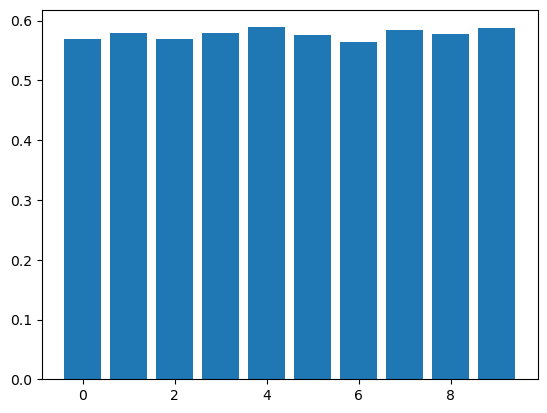

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

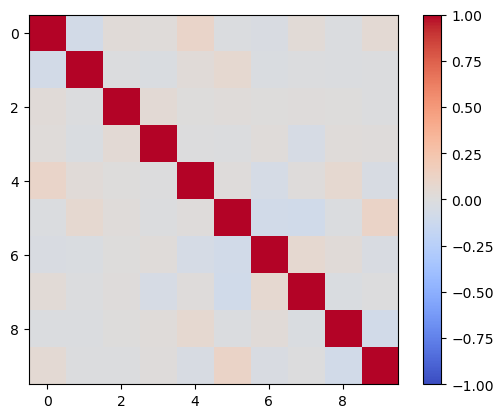

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.9538728, 1: 0.97563416, 2: 0.9460354, 3: 0.95702356, 4: 0.961985, 5: 0.9675559, 6: 0.9608843, 7: 0.9721412, 8: 0.971356, 9: 0.968744}
-------------------VAR-------------------
{0: 0.001887664, 1: 0.0019077297, 2: 0.001765687, 3: 0.00158342, 4: 0.0020369315, 5: 0.0014399645, 6: 0.0018101715, 7: 0.001341305, 8: 0.0023411908, 9: 0.0022408124}


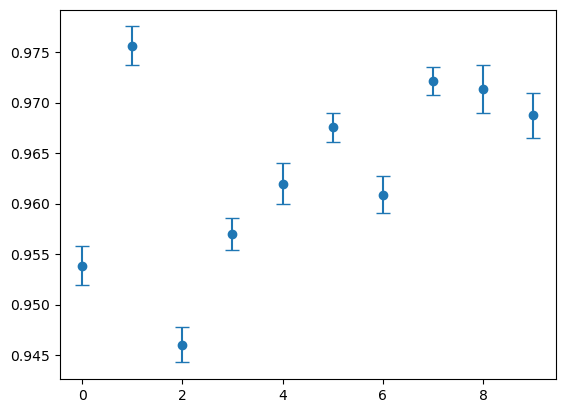

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('body', 'body')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([4.5763e+00, 2.4413e+00, 2.5321e+00, 1.1639e+00, 1.7517e+00, 0.0000e+00,
        3.5230e+00, 3.9342e+00, 5.6966e+00, 0.0000e+00, 0.0000e+00, 1.3511e+00,
        2.9335e+00, 2.5025e+00, 1.9321e-01, 4.6709e+00, 2.2060e+00, 2.2949e+00,
        4.4279e-01, 2.0551e+00, 0.0000e+00, 4.3739e+00, 3.2097e-01, 2.2288e+00,
        2.1863e+00, 5.4541e-01, 3.6262e+00, 3.0774e+00, 2.0128e+00, 6.4864e-02,
        0.0000e+00, 2.3768e-01, 7.2386e+00, 1.8114e+00, 1.5175e+00, 3.4135e+00,
        0.0000e+00, 0.0000e+00, 1.4703e-04, 4.2807e+00, 9.2700e+00, 0.0000e+00,
        1.0518e-01, 0.0000e+00, 0.0000e+00, 4.9215e+00, 2.6224e+00, 2.9900e+00,
        2.1343e+00, 2.3816e+00, 4.6554e-03, 2.1616e+00, 3.1829e+00, 2.5817e+00,
        4.2351e+00, 0.0000e+00, 9.3313e-01, 4.8917e+00, 4.1705e+00, 3.1090e+00,
        7.6829e+00, 0.0000e+00, 0.0000e+00, 7.8008e-01, 1.7619e+00, 1.6125e+00,
        4.5979e+00, 0.0000e+00, 9.2203e-

# Cosine Similarity of Centroid Vectors

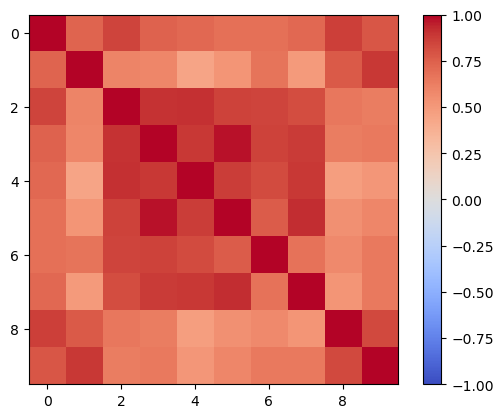

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.9999999  0.7342852  0.8512283  0.7346671  0.71516633 0.6824833
  0.6819921  0.71646357 0.8634485  0.7819243 ]
 [0.7342852  1.0000001  0.5994264  0.58820474 0.44006872 0.5199262
  0.6658525  0.49291852 0.76609117 0.88754296]
 [0.8512283  0.5994264  0.9999999  0.9001473  0.9129684  0.85810745
  0.8489661  0.81543314 0.64952934 0.6323439 ]
 [0.7346671  0.58820474 0.9001473  1.0000002  0.88994914 0.9760123
  0.85357946 0.8750161  0.62665373 0.64787173]
 [0.71516633 0.44006872 0.9129684  0.88994914 1.         0.873122
  0.82283986 0.8856907  0.47082478 0.511473  ]
 [0.6824833  0.5199262  0.85810745 0.9760123  0.873122   1.
  0.75983673 0.91770315 0.5443717  0.5936477 ]
 [0.6819921  0.6658525  0.8489661  0.85357946 0.82283986 0.75983673
  1.         0.67391324 0.57045764 0.6454321 ]
 [0.71646357 0.49291852 0.81543314 0.8750161  0.8856907  0.91770315
  0.67391324 1.0000001  0.5179499  0.6465303 ]
 [0.8634485  0.76609117 0.64952934 0.62665373 0.47082478 0.5443717
  

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.2977, 0.3692, 0.2597, 0.1845, 0.2783, 0.2229, 0.3340, 0.2748, 0.3580,
        0.3065], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.2977, 0.3692, 0.2597, 0.1845, 0.2783, 0.2229, 0.3340, 0.2748, 0.3580,
        0.3065], device='cuda:0', grad_fn=<DiagonalBackward0>)


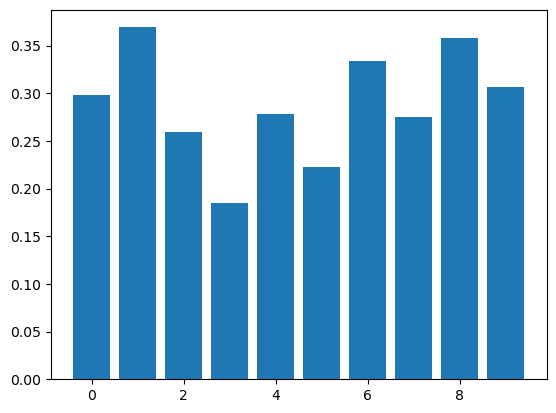

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()